## Problem Statement

People shared a lot of real time information, and news on twitter. It is one of the main-stream communication platform.

Various agencies and organizations are interested in to programatically monitoring Tweets (i.e. disaster relief organizations and news agencies).

However, **words** alone aren't realiable indicators. We would like to have a model that can understand tweets and classify whether the tweet is about a diaster or not.

*Complementory Information*

* Github Repository - https://github.com/wailinkyaww/nlp-disaster-tweets
* W&B Metrics - https://wandb.ai/wailin/NLP%20Diaster%20Tweets?nw=nwuserwailin

Sorry about the typo in W&B project.

## Dataset

The dataset we are going to use has about 10,000 tweets that were hand classified (whether the tweet is about a diaster or not).

It is published by `Figure Eight`. We will start by downloading the dataset from Kaggle.

In [1]:
import os
import wandb
import kagglehub
import pandas as pd

In [ ]:
kagglehub.login()

In [ ]:
wandb.login()

In [5]:
base_path = kagglehub.competition_download(handle='nlp-getting-started')

print(f'Dataset downloaded to: {base_path}')
print(os.listdir(base_path))

100%|██████████| 593k/593k [00:00<00:00, 112MB/s]

Extracting files...
Dataset downloaded to: /root/.cache/kagglehub/competitions/nlp-getting-started
['sample_submission.csv', 'train.csv', 'test.csv']


In [6]:
df_train = pd.read_csv(f"{base_path}/train.csv")
df_test = pd.read_csv(f"{base_path}/test.csv")
df_sample_submission = pd.read_csv(f"{base_path}/sample_submission.csv")

In [7]:
print(df_train.info(), '\n')
print('Target labels:', df_train['target'].unique(), '\n')
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None 

Target labels: [1 0] 



,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Here, we've inspect the full training dataset.

- It contains ~7,600 entries.
- Feature dimension is three including `keyword`, `location`, and `text`, while `text` being the main feature.
- Target (0/1) is our output binary label.

`keyword` and `location` are nullable so we need to do deeper analysis to see how the distribution look like.

In [8]:
print(df_test.info(), '\n')
df_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB
None 



,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [9]:
print(df_sample_submission.info(), '\n')
df_sample_submission.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      3263 non-null   int64
 1   target  3263 non-null   int64
dtypes: int64(2)
memory usage: 51.1 KB
None 



,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


By looking at `test.csv` and `sample_submission.csv` files, we can note that test dataset doesn't contain the prediction labels.

And to submit to kaggle, we have to generate the prediction and format the output dataset in `id` (tweet id) & `target` pairs.

Test dataset contains about 3,000 entries. So this adds up to 10,000 entries in total.

Therefore, we won't split the training dataset. We will use the full dataset to train!

## Exploratory Data Analysis (EDA)

- Inspect, Visualize and Clean the Data
- Show a few visualizations like histograms. Describe any data cleaning procedures.

Based on your EDA, what is your plan of analysis?

### Handles Missing Values

In [10]:
print('Total entries:', df_train.count(), '\n')

# check missing values / na
df_train.isnull().sum()

Total entries: id          7613
keyword     7552
location    5080
text        7613
target      7613
dtype: int64 



,0
id,0
keyword,61
location,2533
text,0
target,0


* **keyword:** 61 entries are missing
* **location:** 2,533 entries are missing

As our dataset is relatively small, instead of dropping rows with these missing values, we will fill with `unknown`.

In [11]:
df_train['keyword'] = df_train['keyword'].fillna('unknown')
df_train['location'] = df_train['location'].fillna('unknown')

### Preprocess Text

As you know, tweets can contain any kind of information. Some are simply not useful for our NLP processing.

We will remove following from the tweet text
* mentions `@`
* http / https urls
* hashtags symbols
* punctuations & numbers

In [12]:
import re

def clean_text(text: str):
  text = text.lower()

  # urls
  text = re.sub(r"http\S+", "", text)

  # leading @
  text = re.sub(r"@\w+", "", text)

  # hashtag
  text = re.sub(r"#", "", text)

  # keep only letters, digits, and spaces
  text = re.sub(r"[^a-z0-9\s]", "", text)

  return text

df_train['clean_text'] = df_train['text'].apply(clean_text)
df_train.head()

,id,keyword,location,text,target,clean_text
0,1,unknown,unknown,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...
1,4,unknown,unknown,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,unknown,unknown,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...
3,6,unknown,unknown,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...
4,7,unknown,unknown,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...


Let's try to visualize the dataset
1. target class distribution (to do imbalance check which is important for modelling)
2. keyword distribution (to see frequence - if some words are diaster prone)
3. text length distribution
4. Word Cloud (this is too see frequent keywords)
5. Token statistics

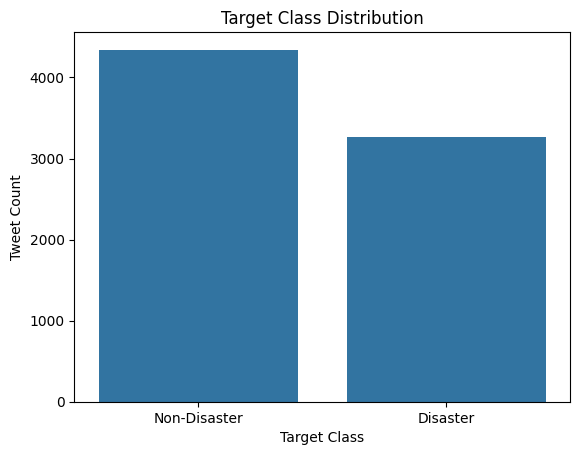

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='target', data=df_train)

plt.title('Target Class Distribution')
plt.xlabel('Target Class')
plt.ylabel('Tweet Count')

# for better readability
plt.xticks(ticks=[0, 1], labels=['Non-Disaster', 'Disaster'])

plt.show()

The difference is about 500. The dataset is not imbalanced and well suited for training.

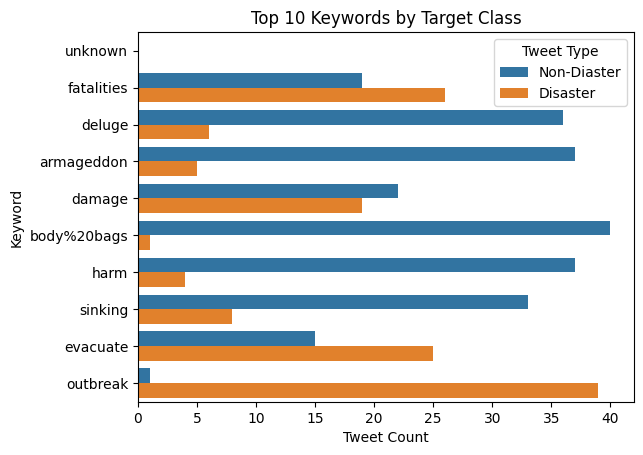

In [14]:
sns.countplot(
    y='keyword',
    data=df_train[df_train['keyword'] != 'unknown'],
    hue='target',
    order=df_train['keyword'].value_counts().iloc[:10].index
)

plt.title('Top 10 Keywords by Target Class')
plt.xlabel('Tweet Count')
plt.ylabel('Keyword')
plt.legend(title='Tweet Type', labels=['Non-Diaster', 'Disaster'])

plt.show()

Here we can see that keywords like `fatalities`, and `outbreak` is mostly associated with diaster tweets.

While the keyword like `damage` has more neutral effect on target label.

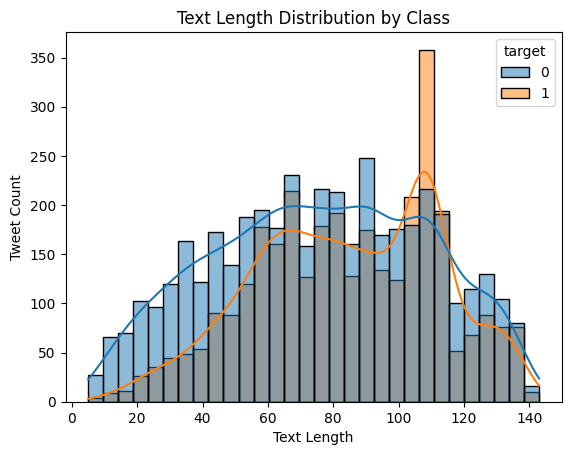

In [15]:
df_train['text_length'] = df_train['clean_text'].apply(len)

sns.histplot(data=df_train, x='text_length', hue='target', bins=30, kde=True)

plt.title('Text Length Distribution by Class')
plt.xlabel('Text Length')
plt.ylabel('Tweet Count')

plt.show()

From the text length distribution, we can see that, non-diaster tweets are longer in length.

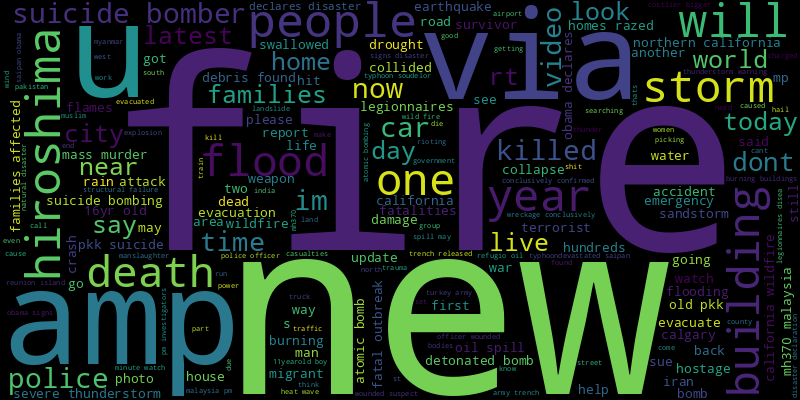

In [16]:
from wordcloud import WordCloud

disaster_text = " ".join(df_train[df_train['target']==1]['clean_text'])
WordCloud(width=800, height=400).generate(disaster_text).to_image()

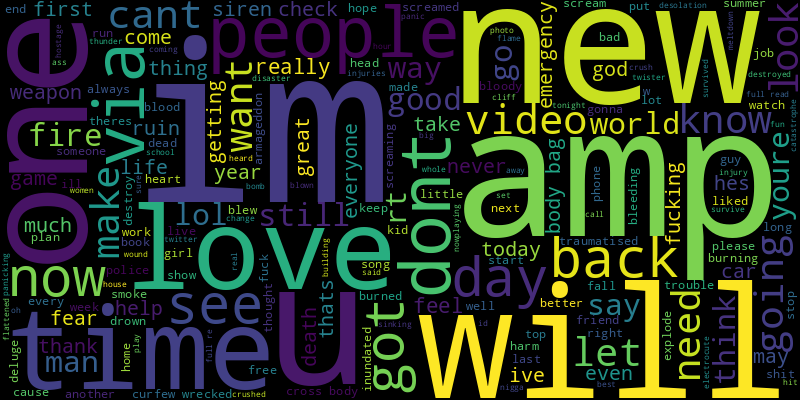

In [17]:
non_disaster_text = " ".join(df_train[df_train['target']==0]['clean_text'])
WordCloud(width=800, height=400).generate(non_disaster_text).to_image()

From this, we can see that keywords like  `fire`, `death`, `hiroshima` are mostly associated with diaster tweets.

On the other hands, the keywords that appears in non-diaster tweets are pretty positive.

----

I think we've explored quite a bit and the data is good enough to do the training.

Let's look into model architecture.

## Model Architecture

We need to handle two parts
1. tokenizing / vectorizing the words
2. training (one of vanilla RNNs, LSTM/GRU, Transformers family)

Using `transformers` is a bit far fetched for our use case. We will start with vanilla RNNs.

### Experiment 1: Vanilla RNN with TF-IDF Vectors

Here we will use TF-IDF to convert texts into fixed-length numerical vectors.
This is simple and easily interpretable. TF-IDF calculates how important a word is in a document relative to the corpus.

We will then feed throught the Simple RNN, although RNNs are typically designed for sequences. This experiment will show us how they perform with flattend features.

In [20]:
import torch as torch

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000)
X_train = tfidf.fit_transform(df_train['clean_text']).toarray()
y_train = df_train['target'].values

class TfidfDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleRNN(nn.Module):
    def __init__(self, input_size=5000, reshape_dims=(100, 50), hidden_size=64):
        super(SimpleRNN, self).__init__()
        self.reshape_dims = reshape_dims
        self.hidden_size = hidden_size
        self.input_size = reshape_dims[1]
        self.sequence_len = reshape_dims[0]

        # input to hidden weights
        self.W_ih = nn.Linear(self.input_size, hidden_size)

        # hidden to hidden weights
        self.W_hh = nn.Linear(hidden_size, hidden_size)

        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = x.view(-1, self.sequence_len, self.input_size)

        batch_size = x.size(0)
        h_t = torch.zeros(batch_size, self.hidden_size, device=x.device)

        for t in range(self.sequence_len):
            x_t = x[:, t, :]
            h_t = torch.tanh(self.W_ih(x_t) + self.W_hh(h_t))

        out = self.dropout(h_t)
        out = self.fc(out)

        return torch.sigmoid(out)

In [22]:
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 32
num_epochs = 30
learning_rate = 1e-3

model = SimpleRNN().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

wandb.init(
    project="NLP Diaster Tweets",
    name="diaster-tweets-vanilla-rnn",
    reinit=True,
    config={
        "epochs": num_epochs,
        "batch_size": batch_size,
        "learning_rate": learning_rate,
        "optimizer": "adam",
        "model": "SimpleRNN"
    }
)

dataset = TfidfDataset(X_train, y_train)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    # tqdm progress bar for batches
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

    for X_batch, y_batch in loop:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        preds = (outputs > 0.5).float()
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

        loop.set_postfix(batch_loss=loss.item())

    epoch_loss = total_loss / len(train_loader)
    epoch_acc = correct / total

    wandb.log({ "epoch": epoch + 1, "loss": epoch_loss, "accuracy": epoch_acc })

    print(f"Epoch {epoch+1}: Loss = {epoch_loss:.4f}, Accuracy = {epoch_acc:.4f}")

wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


Epoch 1: Loss = 0.6824, Accuracy = 0.5667


Epoch 2: Loss = 0.6706, Accuracy = 0.5885


Epoch 3: Loss = 0.6516, Accuracy = 0.6183


Epoch 4: Loss = 0.6418, Accuracy = 0.6339


Epoch 5: Loss = 0.6422, Accuracy = 0.6390


Epoch 6: Loss = 0.6316, Accuracy = 0.6481


Epoch 7: Loss = 0.6168, Accuracy = 0.6531


Epoch 8: Loss = 0.6167, Accuracy = 0.6602


Epoch 9: Loss = 0.6049, Accuracy = 0.6690


Epoch 10: Loss = 0.5965, Accuracy = 0.6800


Epoch 11: Loss = 0.5984, Accuracy = 0.6833


Epoch 12: Loss = 0.5920, Accuracy = 0.6854


Epoch 13: Loss = 0.5866, Accuracy = 0.6929


Epoch 14: Loss = 0.5878, Accuracy = 0.6914


Epoch 15: Loss = 0.5788, Accuracy = 0.6999


Epoch 16: Loss = 0.5757, Accuracy = 0.7048


Epoch 17: Loss = 0.5747, Accuracy = 0.7001


Epoch 18: Loss = 0.5705, Accuracy = 0.7055


Epoch 19: Loss = 0.5682, Accuracy = 0.7097


Epoch 20: Loss = 0.5597, Accuracy = 0.7152


Epoch 21: Loss = 0.5562, Accuracy = 0.7196


Epoch 22: Loss = 0.5516, Accuracy = 0.7256


Epoch 23: Loss = 0.5559, Accuracy = 0.7143


Epoch 24: Loss = 0.5514, Accuracy = 0.7189


Epoch 25: Loss = 0.5539, Accuracy = 0.7201


Epoch 26: Loss = 0.5513, Accuracy = 0.7194


Epoch 27: Loss = 0.5479, Accuracy = 0.7217


Epoch 28: Loss = 0.5439, Accuracy = 0.7253


Epoch 29: Loss = 0.5374, Accuracy = 0.7370


Epoch 30: Loss = 0.5347, Accuracy = 0.7344


After training about 30 epochs, even though the loss reduces gradually, and increases the accuracy alongside, it looks like the learning rate has some problem.

We will try out with learning rate scheduling to see if we can get better training process, and hopefully better results. We will also increase the number of epochs.

In [23]:
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 32
num_epochs = 50
learning_rate = 1e-3

model = SimpleRNN().to(device)
criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)


wandb.init(
    project="NLP Diaster Tweets",
    name="diaster-tweets-vanilla-rnn-2",
    reinit=True,
    config={
        "epochs": num_epochs,
        "batch_size": batch_size,
        "learning_rate": learning_rate,
        "optimizer": "adam",
        "model": "SimpleRNN"
    }
)

dataset = TfidfDataset(X_train, y_train)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    # tqdm progress bar for batches
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

    for X_batch, y_batch in loop:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        preds = (outputs > 0.5).float()
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

        loop.set_postfix(batch_loss=loss.item())

    epoch_loss = total_loss / len(train_loader)
    epoch_acc = correct / total

    wandb.log({
        "epoch": epoch + 1,
        "loss": epoch_loss,
        "accuracy": epoch_acc,
        "lr": optimizer.param_groups[0]['lr']
    })

    scheduler.step()

    print(f"Epoch {epoch+1}: Loss = {epoch_loss:.4f}, Accuracy = {epoch_acc:.4f}")

accuracy,▁▂▃▄▄▄▅▅▅▆▆▆▆▆▆▇▆▇▇▇▇█▇▇▇▇▇███
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▇▇▆▆▆▅▅▄▄▄▄▃▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁
accuracy,0.7344
epoch,30
loss,0.53469


Epoch 1: Loss = 0.6822, Accuracy = 0.5694


Epoch 2: Loss = 0.6684, Accuracy = 0.5865


Epoch 3: Loss = 0.6485, Accuracy = 0.6231


Epoch 4: Loss = 0.6492, Accuracy = 0.6230


Epoch 5: Loss = 0.6420, Accuracy = 0.6279


Epoch 6: Loss = 0.6337, Accuracy = 0.6325


Epoch 7: Loss = 0.6209, Accuracy = 0.6486


Epoch 8: Loss = 0.6168, Accuracy = 0.6494


Epoch 9: Loss = 0.6064, Accuracy = 0.6635


Epoch 10: Loss = 0.5971, Accuracy = 0.6678


Epoch 11: Loss = 0.5866, Accuracy = 0.6862


Epoch 12: Loss = 0.5782, Accuracy = 0.6979


Epoch 13: Loss = 0.5722, Accuracy = 0.6980


Epoch 14: Loss = 0.5635, Accuracy = 0.7104


Epoch 15: Loss = 0.5670, Accuracy = 0.7084


Epoch 16: Loss = 0.5661, Accuracy = 0.7096


Epoch 17: Loss = 0.5621, Accuracy = 0.7115


Epoch 18: Loss = 0.5597, Accuracy = 0.7119


Epoch 19: Loss = 0.5555, Accuracy = 0.7181


Epoch 20: Loss = 0.5558, Accuracy = 0.7159


Epoch 21: Loss = 0.5452, Accuracy = 0.7277


Epoch 22: Loss = 0.5401, Accuracy = 0.7264


Epoch 23: Loss = 0.5382, Accuracy = 0.7294


Epoch 24: Loss = 0.5363, Accuracy = 0.7324


Epoch 25: Loss = 0.5353, Accuracy = 0.7341


Epoch 26: Loss = 0.5296, Accuracy = 0.7398


Epoch 27: Loss = 0.5266, Accuracy = 0.7407


Epoch 28: Loss = 0.5285, Accuracy = 0.7376


Epoch 29: Loss = 0.5252, Accuracy = 0.7440


Epoch 30: Loss = 0.5248, Accuracy = 0.7471


Epoch 31: Loss = 0.5174, Accuracy = 0.7508


Epoch 32: Loss = 0.5164, Accuracy = 0.7469


Epoch 33: Loss = 0.5131, Accuracy = 0.7558


Epoch 34: Loss = 0.5144, Accuracy = 0.7513


Epoch 35: Loss = 0.5132, Accuracy = 0.7552


Epoch 36: Loss = 0.5130, Accuracy = 0.7554


Epoch 37: Loss = 0.5143, Accuracy = 0.7573


Epoch 38: Loss = 0.5119, Accuracy = 0.7570


Epoch 39: Loss = 0.5099, Accuracy = 0.7524


Epoch 40: Loss = 0.5081, Accuracy = 0.7563


Epoch 41: Loss = 0.5070, Accuracy = 0.7613


Epoch 42: Loss = 0.5040, Accuracy = 0.7592


Epoch 43: Loss = 0.5038, Accuracy = 0.7562


Epoch 44: Loss = 0.5061, Accuracy = 0.7573


Epoch 45: Loss = 0.5033, Accuracy = 0.7608


Epoch 46: Loss = 0.5040, Accuracy = 0.7604


Epoch 47: Loss = 0.5041, Accuracy = 0.7617


Epoch 48: Loss = 0.5041, Accuracy = 0.7624


Epoch 49: Loss = 0.5008, Accuracy = 0.7621


Epoch 50: Loss = 0.5002, Accuracy = 0.7622


According to our tracking metrics (Refer to [weights & baises](https://wandb.ai/wailin/NLP%20Diaster%20Tweets?nw=nwuserwailin)), learning rate scheduling does really help.

The accuracy of the new training super passed the old one since around 10 epochs. However, after about 40 epochs, loss and accuracy doesn't improve significantly.

Let's try to create a submission with this.

In [29]:
print(df_test.head())

   id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan


In [33]:
df_test['clean_text'] = df_test['text'].apply(clean_text)

X_test = tfidf.transform(df_test['clean_text']).toarray()
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

model.eval()

with torch.no_grad():
    outputs = model(X_test_tensor)
    preds = (outputs > 0.5).int().cpu().numpy().flatten()

submission_df = pd.DataFrame({ 'id': df_test['id'], 'target': preds })
submission_df.to_csv('simple-rnn-submission.csv', index=False)

print('File saved to simple-rnn-submission.csv.')

File saved to simple-rnn-submission.csv


I got the score of `0.72632` on Kaggle with this submission.

### Experiment 2: Tokenizer + Embedding Layer + LSTM

For this experiment, we will use a tokenizer along with LSTM-based architecture. This will maintain the sequence of words and learns meangingful semantic representations through embedding.

LSTM will also enable to handle longer sequence and contextual information about the tweets.

In [63]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 10000
max_len = 100

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(df_train['clean_text'])

sequences = tokenizer.texts_to_sequences(df_train['clean_text'])
padded = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

labels = df_train['target'].values

We limit the tokenzier to only use top 10,000 words in the dataset as vocabulary.

We also apply paddding and truncating for sequences that are not alignt with length of 100. This is to ensure our model will receive consistent inputs.

In [69]:
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from wandb.integration.keras import WandbMetricsLogger

wandb.init(
    project="NLP Diaster Tweets",
    name="disaster-tweets-lstm",
    reinit=True,
    config={
        "vocab_size": vocab_size,
        "max_len": max_len,
        "embedding_dim": 128,
        "lstm_units": 128,
        "dropout": 0.5,
        "optimizer": "adam",
        "batch_size": 32,
        "epochs": 40,
        "loss": "binary_crossentropy"
    }
)

config = wandb.config

model = Sequential([
    Embedding(input_dim=config.vocab_size, output_dim=config.embedding_dim, input_length=config.max_len),
    LSTM(config.lstm_units),
    Dropout(config.dropout),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=config.optimizer, loss='binary_crossentropy', metrics=['accuracy'])

print(model.summary())

model.fit(
    padded,
    labels,
    batch_size=config.batch_size,
    epochs=config.epochs,
    callbacks=[WandbMetricsLogger()]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/40
238/238 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.5715 - loss: 0.6852
Epoch 2/40
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5778 - loss: 0.6824
Epoch 3/40
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5645 - loss: 0.6867
Epoch 4/40
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5653 - loss: 0.6857
Epoch 5/40
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5773 - loss: 0.6820
Epoch 6/40
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5671 - loss: 0.6855
Epoch 7/40
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5619 - loss: 0.6866
Epoch 8/40
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5779 - loss: 0.6814
Epoch 9/40
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5706 - loss: 0.6835
Epoch 10/40
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5706 - loss: 0.6833
Epoch 11/40
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5661 - loss: 0.6850
Epoch 12/40
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 11

In [72]:
test_sequences = tokenizer.texts_to_sequences(df_test['clean_text'])
test_padded = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')

pred_probs = model.predict(test_padded, batch_size=32)
preds = (pred_probs > 0.5).astype(int).flatten()

submission_df = pd.DataFrame({
    'id': df_test['id'],
    'target': preds
})

submission_df.to_csv('lstm-submission.csv', index=False)

print("Saved to lstm-submission.csv")

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Saved to lstm-submission.csv


## Results and Analysis

We explored two modeling strategies for classifying disaster tweets:
* Experiment 1: TF-IDF + SimpleRNN (custom RNN layer)
* Experiment 2: Tokenizer + Embedding + LSTM


| Feature                   | **Experiment 1: SimpleRNN + TF-IDF** | **Experiment 2: LSTM + Tokenizer** |
|----------------------------------|--------------------------------------|------------------------------------|
| Input Representation             | TF-IDF vectors (flat, no word order) | Tokenized sequences (word order preserved) |
| Model Architecture               | SimpleRNN                     | Embedding + LSTM                   |
| Learning Rate Scheduler          | StepLR (after 10 epochs)           |  -                            |
| Training Epochs                  | 50                                   | 50                                 |
| Training Accuracy (Best)         | Improves after epoch 10, ~0.80+    |  Stuck around ~0.56              |
| Loss Curve Behavior              | Improves steadily with scheduler     | non converging              |
| Kaggle Submission Accuracy       | **0.72632**                          | 0.57033                            |
| Early Epoch Learning             | ~70% by epoch 10          | Weak — ~0.56 from start         |
| Overall Stability & Effectiveness| Good                               | Poor                            |

**What Helped Improve Performance?**

1. Learning rate scheduling made a significant difference. Without it, SimpleRNN model had a poor loss curve. With StepLR, it began learning properly after epoch 10 and improved until epoch 40.
2. Simpler TF-IDF + SimpleRNN was unexpectedly more effective than LSTM, likely due to easier optimization and fewer parameters. I expected LSTM to work better, maybe it will work on larger parameters and bigger dataset.
3. Logging with W&B made it easier to identify when learning had plateaued and guided when to adjust the learning rate.

**What Did Not Help?**

1. LSTM model with raw tokenized inputs failed to learn. Accuracy was stuck around 0.56 even after long training.
2. Training embeddings from scratch may have been insufficient for the LSTM to extract useful features.
3. Lack of validation made it harder to detect overfitting or other learning dynamics during training.

## Conclusion

Despite its simplicity, the TF-IDF + SimpleRNN approach outperformed LSTM — with a Kaggle score of 0.72632.

LSTM model should theoretically perform better than a vanilla RNN. But it failed. This is most likely because of
1. Lack of pretrained embeddings
2. Shallow architecture (we could try more params with deeper layers & more training samples)

**Future Improvements**
I would consider followings in future:
* Use pretreind embedding models
* Try out with GRU and Bi-directional LSTM
* Add a validation dataset (I didn't because the dataset was too small)
* Try out with transformers based models
